## Experimental results : denoising a known covariance matrix

We generate a vector of means and a covariance matrix out of 10 blocks of size 50 each, where off-diagonal elements within each block have a correlation of 0.5.

- This covariance matrix is a stylized representation of a “true” (non-empirical) de-toned correlation
matrix of the S&P 500, where each block is associated with an economic sector.

- Without loss of generality, the variances are drawn from a uniform distribution bounded between
5% and 20%, and the vector of means is drawn from a Normal distribution with mean and standard
deviation equal to the standard deviation from the covariance matrix.

We will compute the minimum variance portfolio weight using the real covariance (w_minv), the empirical covariance matrix (w_minv_hat) and the clipped covariance matrix (w_minv_cleaned). And compare how close is w_minv_hat to w_minv compared to how close is w_minv_cleaned to w_minv.

In [16]:
# Import library
import numpy as np
from scipy.linalg import block_diag
import seaborn as sns
from functions import calculate_portfolio_return, clipping_cov, linear_shrinkage_cov

#### The real covariance matrix

In [17]:
# Generate our covariance matrix
Nb_blocks = 10
block_size = 50
block_list = []
for i in range(Nb_blocks):
    sd = np.sqrt(np.random.uniform(0.05 / np.sqrt(252), 0.2 / np.sqrt(252),50))
    sd = sd[:,np.newaxis]
    C = sd @ np.transpose(sd) 
    diag = np.diag(C)
    C = C * 0.5
    np.fill_diagonal(C, diag)
    block_list.append(C)

Cov = block_diag(*block_list)

# Generate mean
sd = np.sqrt(np.diag(Cov))
mu = np.random.multivariate_normal(sd, Cov)

<Axes: >

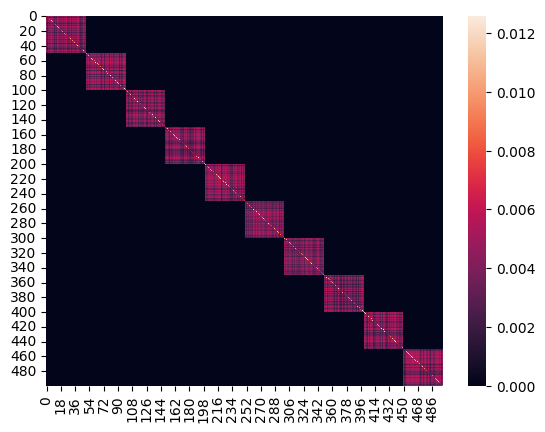

In [18]:
sns.heatmap(Cov)

In [19]:
# The minimum-variance weight 
ones = np.ones((500,1))
Cov_inv = np.linalg.inv(Cov)
w_minv = Cov_inv @ ones / (np.transpose(ones) @ Cov_inv @ ones)

In [20]:
# Simulation and estimation of error

Nb_simulation = 100
rmse_hat = []
rmse_clipping = []
rmse_ls = []
rmse_ts = []
for i in range(Nb_simulation):
    T = 1000
    # Generate observation matrix X
    X = np.random.multivariate_normal(mu, Cov, T)
    # Estimation without denoising
    mu_hat = np.mean(X, axis = 0)
    mu_hat = mu_hat[:,np.newaxis]
    Cov_hat = 1 / T * np.transpose(X) @ X - mu_hat @ np.transpose(mu_hat)
    Cov_hat[Cov_hat < 0] = 0
    Cov_hat_inv = np.linalg.inv(Cov_hat)
    w_minv_hat = Cov_hat_inv @ ones / (np.transpose(ones) @ Cov_hat_inv @ ones)
    rmse_hat.append(np.sqrt(np.mean((w_minv_hat-w_minv)**2)))
    
    # Estimation with clipping
    Cov_cleaned = clipping_cov(Cov_hat, T, Nb_blocks * block_size)
    Cov_cleaned_inv = np.linalg.inv(Cov_cleaned)
    w_minv_cleaned = Cov_cleaned_inv @ ones / (np.transpose(ones) @ Cov_cleaned_inv @ ones)
    rmse_minv_cleaned = np.sqrt(np.mean((w_minv_cleaned-w_minv)**2))
    rmse_clipping.append(rmse_minv_cleaned)

    # Estimation with ls with alpha = 1/2
    Cov_ls = linear_shrinkage_cov(Cov_hat,1/2)
    Cov_ls_inv = np.linalg.inv(Cov_ls)
    w_minv_ls = Cov_ls_inv @ ones / (np.transpose(ones) @ Cov_ls_inv @ ones)
    rmse_minv_ls = np.sqrt(np.mean((w_minv_ls-w_minv)**2))
    rmse_ls.append(rmse_minv_ls)

    # Estimation with ls with alpha = 1
    Cov_ts = linear_shrinkage_cov(Cov_hat,1)
    Cov_ts_inv = np.linalg.inv(Cov_ts)
    w_minv_ts = Cov_ts_inv @ ones / (np.transpose(ones) @ Cov_ts_inv @ ones)
    rmse_minv_ts = np.sqrt(np.mean((w_minv_ts-w_minv)**2))
    rmse_ts.append(rmse_minv_ts)
    

We see that clipping estimates the covariance matrix way better than empirical covariance.

In [21]:
print("emp" ,np.mean(rmse_hat) , np.std(rmse_hat))
print("clip" , np.mean(rmse_clipping) , np.std(rmse_clipping))
print("ls" , np.mean(rmse_ls) , np.std(rmse_ls))
print("ts" , np.mean(rmse_ts), np.std(rmse_ts))

emp 0.0069919874166108845 0.0009360127154109282
clip 0.0023423411852813323 4.625840072127377e-05
ls 0.002856737047784092 5.659691589308887e-05
ts 0.007274798760251544 4.714010997513419e-06


## Experimental results : denoising a empirical covariance matrix for out sample meanvariance portfolio

In this part, we will optimize portfolio weight using minimum variance on US stocks data from 2010-01-01 to 2024-01-01. We will use a rolling window methodology, where we use 1000 days to estimate covariance and keep the portfolio weight we get for the next 60 days and so on. At the end, we will compute the standard deviation of the portfolio obtained using the different estimation methods and compare them.

In [22]:
# import yahoo finance, pandas etc
import yfinance as yf
import pandas as pd
from datetime import datetime
from IPython.display import clear_output


In [23]:
# list of tickers
tickers = ['MMM', 'ABT', 'ABBV', 'ACN', 'ATVI', 'AYI', 'ADBE', 'AMD', 'AAP', 'AES', 'AET', 'AMG', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 
           'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'AGN', 'ADS', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AAL', 'AEE', 'AEP', 
           'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 
           'APA', 'AIV', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ARNC', 'AJG', 'AIZ', 'T', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BHGE', 
           'BLL', 'BAC', 'BK', 'BAX', 'BBT', 'BDX', 'BRK.B', 'BBY', 'BIIB', 'BLK', 'HRB', 'BA', 'BWA', 'BXP', 'BSX', 'BHF', 'BMY', 
           'AVGO', 'BF.B', 'CHRW', 'CA', 'COG', 'CDNS', 'CPB', 'COF', 'CAH', 'CBOE', 'KMX', 'CCL', 'CAT', 'CBG', 'CBS', 'CELG', 
           'CNC', 'CNP', 'CTL', 'CERN', 'CF', 'SCHW', 'CHTR', 'CHK', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'XEC', 'CINF', 'CTAS', 
           'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'CXO', 'COP', 'ED', 'STZ', 
           'COO', 'GLW', 'COST', 'COTY', 'CCI', 'CSRA', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA', 'DE', 'DAL', 'XRAY', 'DVN',
           'DLR', 'DFS', 'DISCA', 'DISCK', 'DISH', 'DG', 'DLTR', 'D', 'DOV', 'DPS', 'DTE', 'DRE', 'DUK', 'DXC', 'ETFC', 
           'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'EMR', 'ETR', 'EVHC', 'EOG', 'EQT', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 
           'ES', 'RE', 'EXC', 'EXPE', 'EXPD', 'ESRX', 'EXR', 'XOM', 'FFIV', 'FB', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FE', 'FISV',
           'FLIR', 'FLS', 'FLR', 'FMC', 'FL', 'F', 'FTV', 'FBHS', 'BEN', 'FCX', 'GPS', 'GRMN', 'IT', 'GD', 'GE', 'GGP', 'GIS', 'GM',
           'GPC', 'GILD', 'GPN', 'GS', 'GT', 'GWW', 'HAL', 'HBI', 'HOG', 'HIG', 'HAS', 'HCA', 'HCP', 'HP', 'HSIC', 'HSY', 
           'HES', 'HPE', 'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HPQ', 'HUM', 'HBAN', 'HII', 'IDXX', 'INFO', 'ITW', 'ILMN', 'IR',
           'INTC', 'ICE', 'IBM', 'INCY', 'IP', 'IPG', 'IFF', 'INTU', 'ISRG', 'IVZ', 'IQV', 'IRM', 'JEC', 'JBHT', 'SJM', 'JNJ', 
           'JCI', 'JPM', 'JNPR', 'KSU', 'K', 'KEY', 'KMB', 'KIM', 'KMI', 'KLAC', 'KSS', 'KHC', 'KR', 'LB', 'LH', 'LRCX', 
           'LEG', 'LEN', 'LUK', 'LLY', 'LNC', 'LKQ', 'LMT', 'L', 'LOW', 'LYB', 'MTB', 'MAC', 'M', 'MRO', 'MPC', 'MAR', 'MMC', 
           'MLM', 'MAS', 'MA', 'MAT', 'MKC', 'MCD', 'MCK', 'MDT', 'MRK', 'MET', 'MTD', 'MGM', 'KORS', 'MCHP', 'MU', 'MSFT', 'MAA', 
           'MHK', 'TAP', 'MDLZ', 'MON', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MYL', 'NDAQ', 'NOV', 'NAVI', 'NTAP', 'NFLX', 'NWL', 
           'NFX', 'NEM', 'NWSA', 'NWS', 'NEE', 'NLSN', 'NKE', 'NI', 'NBL', 'JWN', 'NSC', 'NTRS', 'NOC', 'NCLH', 'NRG', 'NUE', 
           'NVDA', 'ORLY', 'OXY', 'OMC', 'OKE', 'ORCL', 'PCAR', 'PKG', 'PH', 'PDCO', 'PAYX', 'PYPL', 'PNR', 'PBCT', 'PEP', 'PKI', 
           'PRGO', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'RL', 'PPG', 'PPL', 'PX', 'PCLN', 'PFG', 'PG', 'PGR', 'PLD', 
           'PRU', 'PEG', 'PSA', 'PHM', 'PVH', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RRC', 'RJF', 'RTN', 'O', 'REG', 'REGN', 'RF', 
           'RSG', 'RMD', 'RHI', 'ROK', 'COL', 'ROP', 'ROST', 'RCL', 'CRM', 'SBAC', 'SLB', 'STX', 'SEE', 'SRE', 'SHW', 
           'SIG', 'SPG', 'SWKS', 'SLG', 'SNA', 'SO', 'LUV', 'SPGI', 'SWK', 'SBUX', 'STT', 'SRCL', 'SYK', 'STI', 'SYMC', 'SYF', 
           'SNPS', 'SYY', 'TROW', 'TPR', 'TGT', 'TEL', 'FTI', 'TXN', 'TXT', 'TMO', 'TIF', 'TWX', 'TJX', 'TSS', 'TSCO', 
           'TDG', 'TRV', 'TRIP', 'FOXA', 'FOX', 'TSN', 'UDR', 'ULTA', 'USB', 'UAA', 'UA', 'UNP', 'UAL', 'UNH', 'UPS', 'URI', 'UTX', 
           'UHS', 'UNM', 'VFC', 'VLO', 'VAR', 'VTR', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VIAB', 'V', 'VNO', 'VMC', 'WMT', 'WBA', 'DIS', 
           'WM', 'WAT', 'WEC', 'WFC', 'HCN', 'WDC', 'WU', 'WRK', 'WY', 'WHR', 'WMB', 'WLTW', 'WYN', 'WYNN', 'XEL', 'XRX', 'XLNX', 
           'XL', 'XYL', 'YUM', 'ZBH', 'ZION', 'ZTS']

In [24]:
path = "stock_data.pkl"
try:
    dr = pd.read_pickle("./stock_data.pkl")
except:
    data_source = "yahoo"
    start_day, end_day = "2010-01-01", "2024-01-01"

    df = pd.DataFrame()
    for ticker in tickers:
        try:
            dfTemp = yf.download(ticker, start_day, end_day)
            dfTemp = dfTemp.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"])
            dfTemp.columns = [ticker]
            if dfTemp[ticker].min() > 0:
                df = pd.concat([df, dfTemp], axis = 1)
        except RemoteDataError:
            print("Ticker ", ticker, " not available")
    clear_output()
    dr = df.dropna(axis=1)
    dr.to_pickle("./stock_data.pkl")

In [25]:
returns = dr.pct_change()
returns = returns.dropna()
returns.index = range(len(returns))
(T, N) = returns.shape

In [26]:
ret = calculate_portfolio_return(1000, 60, returns, T, N, 0)
ret_clip = calculate_portfolio_return(1000, 60, returns, T, N, 1)
ret_ls = calculate_portfolio_return(1000, 60, returns, T, N, 2)
ret_ts = calculate_portfolio_return(1000, 60, returns, T, N, 3)

In [27]:
print("emp",np.std(ret) * np.sqrt(252))
print("clip",np.std(ret_clip)*np.sqrt(252))
print("ls", np.std(ret_ls)*np.sqrt(252))
print("ts", np.std(ret_ts)*np.sqrt(252))

emp 0.17694728021886635
clip 0.1591422148608032
ls 0.15776120759219045
ts 0.17038487331820173
